# 🎯 Object Detection Task

## 📚 Import necessary libraries

In [1]:
import os
import yaml
import glob
import random
import matplotlib.pyplot as plt

from roboflow import Roboflow
from collections import defaultdict
from matplotlib.patches import Rectangle

## 📥 Dataset Downloads

In [ ]:
rf = Roboflow(api_key="xxxxx")  # Replace with your actual API key

In [3]:
# Breast Cancer Detection
project = rf.workspace("med-2fnb4").project("cancer-detection-dataset-vrorj")
version = project.version(2)
dataset = version.download("yolov11", location="Data/BreastCancer")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Data/BreastCancer in yolov11:: 100%|██████████| 5034/5034 [00:00<00:00, 22465.16it/s]


In [4]:
# Blood Cell Detection
project = rf.workspace("med-2fnb4").project("blood-cell-dataset-qbrgd")
version = project.version(3)
dataset = version.download("yolov11", location="Data/BloodCell")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Data/BloodCell in yolov11:: 100%|██████████| 8796/8796 [00:00<00:00, 20905.02it/s]


In [5]:
# Fracture Detection
project = rf.workspace("med-2fnb4").project("fracture-dataset-btrwc")
version = project.version(2)
dataset = version.download("yolov11", location="Data/Fracture")   

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Data/Fracture in yolov11:: 100%|██████████| 27112/27112 [00:01<00:00, 19976.65it/s]


## 📊 Dataset Analysis

In [6]:
def analyze_dataset_distribution(path):
    splits = ['train', 'valid', 'test']
    class_counts = defaultdict(int)
    split_class_counts = {split: defaultdict(int) for split in splits}
    split_image_counts = {split: 0 for split in splits}
    object_counts_per_image = []
    
    # Read data.yaml for class names
    data_yaml_path = os.path.join(path, 'data.yaml')
    class_names = []
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, 'r') as f:
            data = yaml.safe_load(f)
            class_names = data.get('names', [])
    
    for split in splits:
        label_dir = os.path.join(path, split, 'labels')
        image_dir = os.path.join(path, split, 'images')
        
        if os.path.exists(label_dir):
            for label_file in glob.glob(os.path.join(label_dir, '*.txt')):
                lines = []
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                object_count = len([line for line in lines if line.strip()])
                object_counts_per_image.append(object_count)
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
                        split_class_counts[split][class_id] += 1
        
        if os.path.exists(image_dir):
            split_image_counts[split] = len(glob.glob(os.path.join(image_dir, '*.jpg'))) + len(glob.glob(os.path.join(image_dir, '*.png')))
    
    num_classes = len(class_counts)
    dataset_name = os.path.basename(path)
    
    if num_classes <= 1:
        # 2 subplots: Overall class dist and Histogram of object count per image
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"Distribution Analysis for {dataset_name}")
        
        # Plot 1: Overall class distribution
        classes = sorted(class_counts.keys())
        counts = [class_counts[c] for c in classes]
        colors = plt.cm.tab10.colors[:len(classes)]
        bars = ax1.bar([class_names[c] if c < len(class_names) else f'Class {c}' for c in classes], counts, color=colors)
        ax1.set_title('Overall Class Distribution')
        ax1.set_ylabel('Count')
        ax1.legend(bars, [class_names[c] if c < len(class_names) else f'Class {c}' for c in classes])
        
        # Plot 2: Histogram of object count per image
        ax2.hist(object_counts_per_image, bins=range(min(object_counts_per_image), max(object_counts_per_image)+2), edgecolor='black', alpha=0.7)
        ax2.set_title('Histogram of Object Count by Image')
        ax2.set_xlabel('Number of Objects per Image')
        ax2.set_ylabel('Number of Images')
        
        plt.tight_layout()
        plt.show()
    else:
        # 2x2 grid: Overall class dist, Class per split, Images per split, Histogram
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f"Distribution Analysis for {dataset_name}")
        
        # Plot 1: Overall class distribution
        classes = sorted(class_counts.keys())
        counts = [class_counts[c] for c in classes]
        colors = plt.cm.tab10.colors[:len(classes)]
        bars = ax1.bar([class_names[c] if c < len(class_names) else f'Class {c}' for c in classes], counts, color=colors)
        ax1.set_title('Overall Class Distribution')
        ax1.set_ylabel('Count')
        ax1.legend(bars, [class_names[c] if c < len(class_names) else f'Class {c}' for c in classes])
        
        # Plot 2: Class distribution per split (stacked bar)
        splits_list = list(splits)
        class_ids = sorted(set(c for counts in split_class_counts.values() for c in counts.keys()))
        bottom = [0] * len(splits_list)
        for i, class_id in enumerate(class_ids):
            counts = [split_class_counts[split][class_id] for split in splits_list]
            color = plt.cm.tab10.colors[i % 10]
            ax2.bar(splits_list, counts, bottom=bottom, label=class_names[class_id] if class_id < len(class_names) else f'Class {class_id}', color=color)
            bottom = [b + c for b, c in zip(bottom, counts)]
        ax2.set_title('Class Distribution per Split')
        ax2.set_ylabel('Count')
        ax2.legend()
        
        # Plot 3: Images per split
        ax3.bar(split_image_counts.keys(), split_image_counts.values(), color='skyblue')
        ax3.set_title('Number of Images per Split')
        ax3.set_ylabel('Number of Images')
        
        # Plot 4: Histogram of object count per image
        ax4.hist(object_counts_per_image, bins=range(min(object_counts_per_image) if object_counts_per_image else 0, (max(object_counts_per_image) if object_counts_per_image else 1)+2), edgecolor='black', alpha=0.7)
        ax4.set_title('Histogram of Object Count by Image')
        ax4.set_xlabel('Number of Objects per Image')
        ax4.set_ylabel('Number of Images')
        
        plt.tight_layout()
        plt.show()

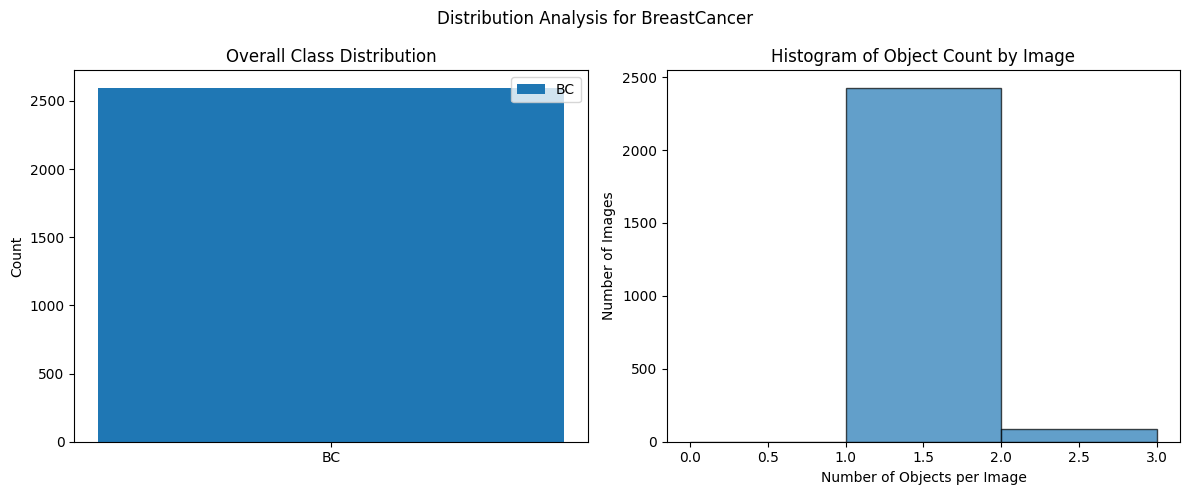

In [7]:
analyze_dataset_distribution("Data/BreastCancer")

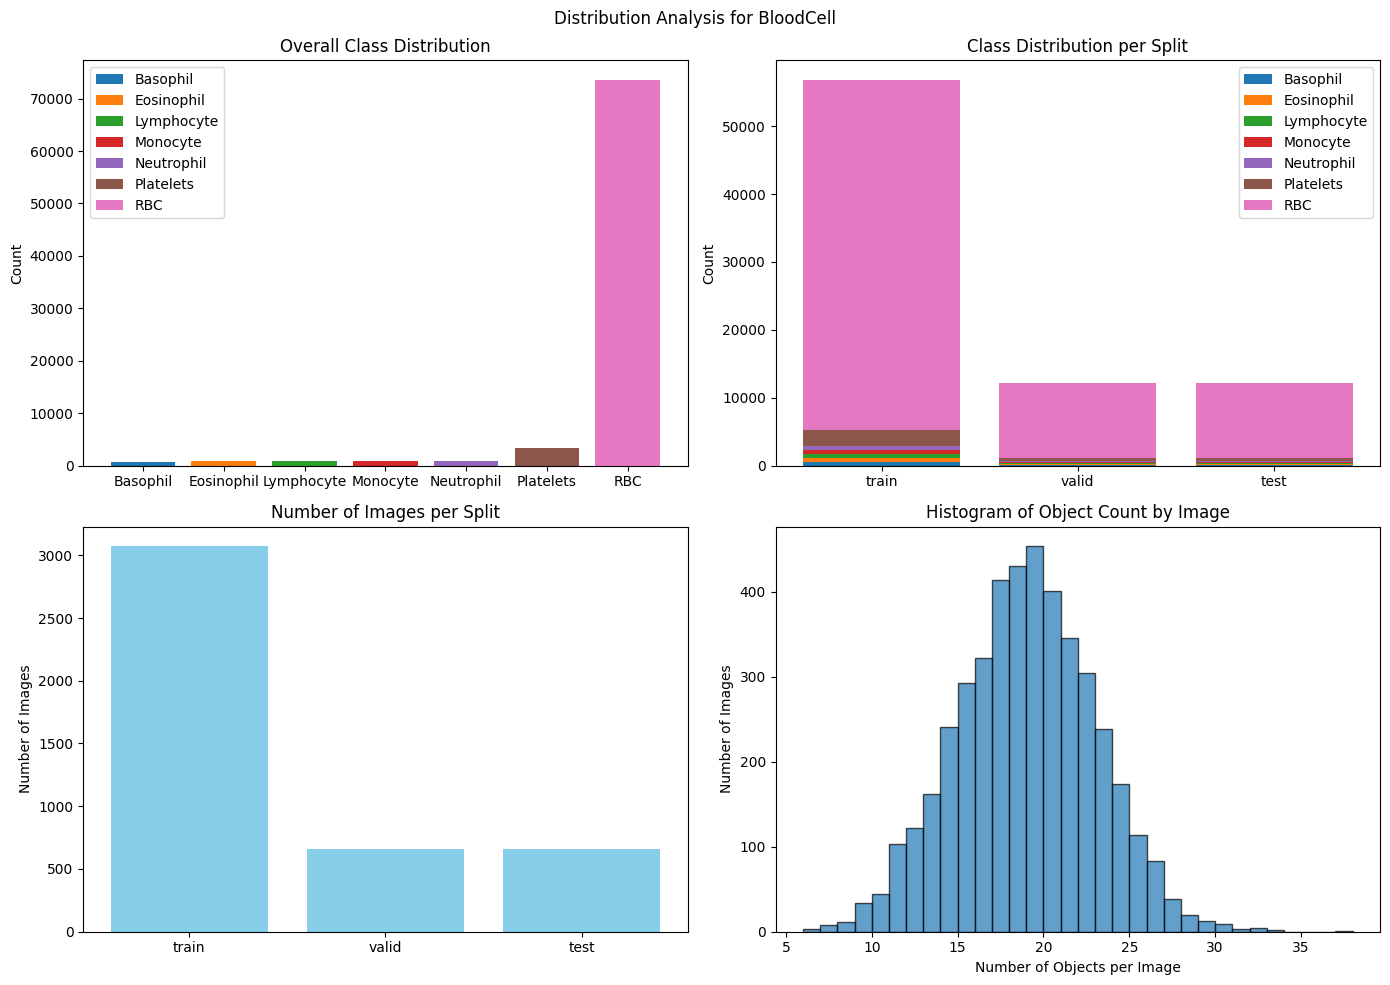

In [8]:
analyze_dataset_distribution("Data/BloodCell")

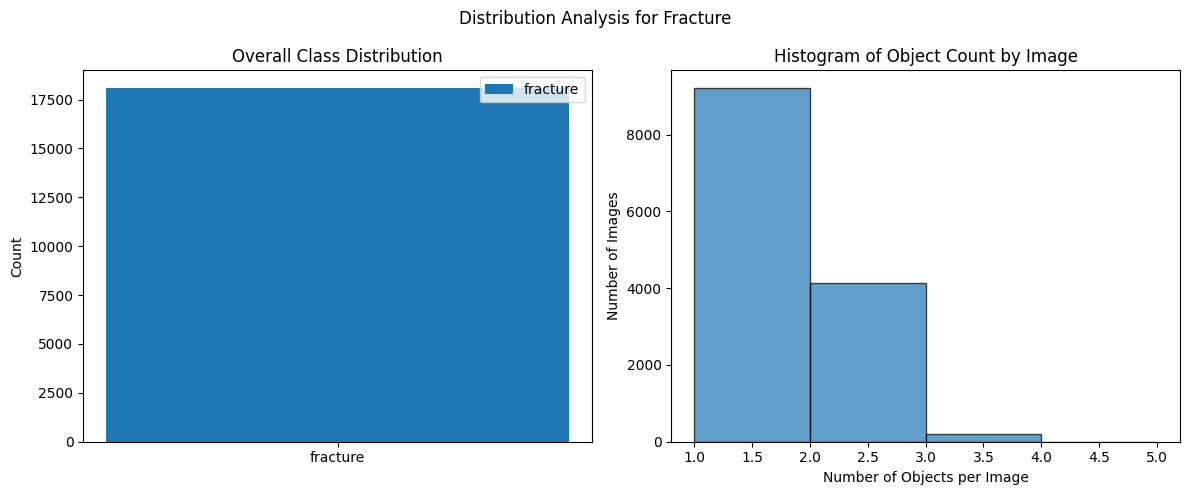

In [13]:
analyze_dataset_distribution("Data/Fracture")

## 🖼️ Example Images with Annotations

In [9]:
def display_example_images(path, num_examples=3):
    image_dir = os.path.join(path, 'train', 'images')
    label_dir = os.path.join(path, 'train', 'labels')
    
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        print(f"Directories not found for {path}")
        return
    
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    if len(image_files) < num_examples:
        num_examples = len(image_files)
    
    selected_images = random.sample(image_files, num_examples)
    
    # Read class names
    data_yaml_path = os.path.join(path, 'data.yaml')
    class_names = []
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, 'r') as f:
            data = yaml.safe_load(f)
            class_names = data.get('names', [])
    
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    if num_examples == 1:
        axes = [axes]
    
    dataset_name = os.path.basename(path)
    fig.suptitle(f"Example Images with Annotations from {dataset_name} Training Set")
    
    for i, img_path in enumerate(selected_images):
        ax = axes[i]
        img = plt.imread(img_path)
        ax.imshow(img)
        
        # Get label file
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(label_dir, base_name + '.txt')
        
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        
                        # Denormalize
                        img_h, img_w = img.shape[:2]
                        x1 = (x_center - width/2) * img_w
                        y1 = (y_center - height/2) * img_h
                        x2 = (x_center + width/2) * img_w
                        y2 = (y_center + height/2) * img_h
                        
                        color = plt.cm.tab10.colors[class_id % 10]
                        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
                        ax.add_patch(rect)
                        
                        label = class_names[class_id] if class_id < len(class_names) else f'Class {class_id}'
                        ax.text(x1, y1 - 5, label, color=color, fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.7))
        
        ax.axis('off')
    
    plt.show()

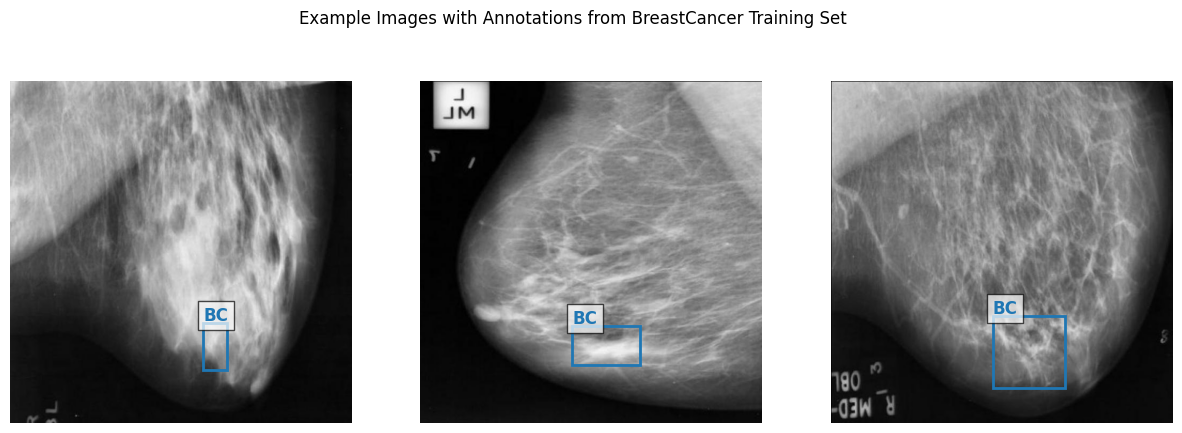

In [10]:
# Breast Cancer
display_example_images("Data/BreastCancer")

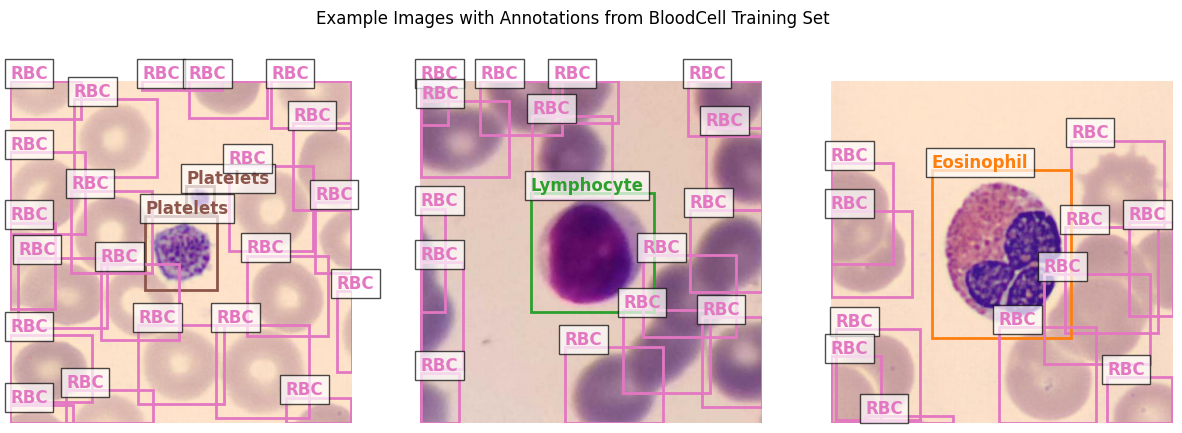

In [11]:
# Blood Cell
display_example_images("Data/BloodCell")

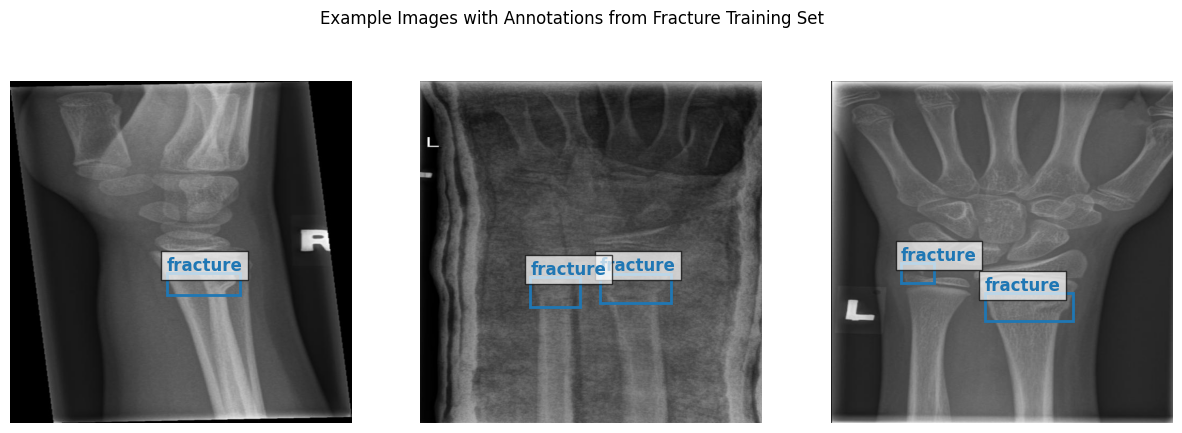

In [12]:
# Fracture
display_example_images("Data/Fracture")

## 📚 Datasets and Model References

### 🤖 Object Detection Model — YOLO11 (Ultralytics)

Citation:

Ultralytics. *Ultralytics YOLO11*. Version 11.0.0, 2024.
[📦 GitHub Repository](https://github.com/ultralytics/ultralytics)

> Ultralytics has not published a formal research paper for YOLO11.

---

### 💀 Fracture Detection Dataset

📦 [Dataset (Roboflow)](https://universe.roboflow.com/med-2fnb4/fracture-dataset-btrwc)

**Citation:**
Med. *Fracture Dataset*. Roboflow Universe, 2025.

---

### 🧫 Breast Cancer Detection Dataset

📦 [Dataset (Roboflow)](https://universe.roboflow.com/med-2fnb4/cancer-detection-dataset-vrorj)

**Citation:**
Med. *Cancer Detection Dataset*. Roboflow Universe, 2025.

---

### 🩸 Blood Cell Dataset

📦 [Dataset (Roboflow)](https://universe.roboflow.com/med-2fnb4/blood-cell-dataset-qbrgd)

**Citation:**
Med. *Blood Cell Dataset*. Roboflow Universe, 2025.
